In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm

In [3]:
df = pd.read_excel('proshares_analysis_data.xlsx', sheet_name='hedge_fund_series')
df

,Unnamed: 0,HFRIFWI Index,MLEIFCTR Index,MLEIFCTX Index,HDG US Equity,QAI US Equity
0,2011-08-31,-0.032149,-0.025588,-0.025689,-0.027033,-0.006492
1,2011-09-30,-0.038903,-0.032414,-0.032593,-0.032466,-0.022142
2,2011-10-31,0.026858,0.043593,0.043320,0.050531,0.025244
3,2011-11-30,-0.013453,-0.012142,-0.012431,-0.028608,-0.007965
4,2011-12-31,-0.004479,0.001938,0.001796,0.012874,0.001818
...,...,...,...,...,...,...
165,2025-05-31,0.022300,0.019974,0.019702,0.018973,0.019302
166,2025-06-30,0.023300,0.011474,0.010798,0.010599,0.015305
167,2025-07-31,0.009700,0.012114,0.011396,0.009106,0.006813
168,2025-08-31,0.022100,0.013347,0.013024,0.013858,0.015052


In [4]:
df.rename(columns={'Unnamed: 0': 'Date'}, inplace=True)
df.set_index('Date', inplace=True)
df.head()

,HFRIFWI Index,MLEIFCTR Index,MLEIFCTX Index,HDG US Equity,QAI US Equity
Date,,,,,
2011-08-31,-0.032149,-0.025588,-0.025689,-0.027033,-0.006492
2011-09-30,-0.038903,-0.032414,-0.032593,-0.032466,-0.022142
2011-10-31,0.026858,0.043593,0.043320,0.050531,0.025244
2011-11-30,-0.013453,-0.012142,-0.012431,-0.028608,-0.007965
2011-12-31,-0.004479,0.001938,0.001796,0.012874,0.001818


## 1. For the series in the “hedge fund series” tab, report the following summary statistics:
- Mean
- Volatility
- Sharpe ratio

Annualize these statistics.

In [5]:
summ = pd.DataFrame(index=df.columns, columns=['Mean', 'Volatility', 'Sharpe'])

summ['Mean'] = df.mean() * 12
summ['Volatility'] = df.std() * np.sqrt(12)
summ['Sharpe'] = summ['Mean'] / summ['Volatility']
summ

,Mean,Volatility,Sharpe
HFRIFWI Index,0.051279,0.058796,0.872151
MLEIFCTR Index,0.038535,0.055240,0.697589
MLEIFCTX Index,0.036526,0.055102,0.662880
HDG US Equity,0.026880,0.057388,0.468396
QAI US Equity,0.028811,0.049823,0.578275


## 2. For the series in the “hedge fund series” tab, calculate the following statistics related to tail-risk.

- Skewness
- Excess Kurtosis (in excess of 3)
- VaR (.05) - the fifth quantile of historic returns
- CVaR (.05) - the mean of the returns at or below the fifth quantile
- Maximum drawdown - include the dates of the max/min/recovery within the max drawdown period.

There is no need to annualize any of these statistics.

In [6]:
summ['Skewness'] = df.skew()
summ['Excess Kurtosis'] = df.kurtosis()  # .kurtosis() automatically calculates excess (kurt - 3)
summ['VaR'] = df.quantile(.05)
summ['CVaR'] = df[df <= summ['VaR']].mean()

cum_val = (1 + df).cumprod()
peak = cum_val.cummax()
dd = (cum_val - peak) / peak
summ['Max Drawdown'] = dd.min()
summ['Bottom'] = dd.idxmin()

for col in df.columns:
    bottom_date = summ.loc[col, 'Bottom']
    peak_date = cum_val[col].loc[:bottom_date].idxmax()
    post_bottom = cum_val[col].loc[bottom_date:]
    recovery_date = post_bottom[post_bottom >= cum_val[col].loc[peak_date]].index.min()
    summ.loc[col, 'Peak'] = peak_date
    summ.loc[col, 'Recovery'] = recovery_date

summ.round(3)

,Mean,Volatility,Sharpe,Skewness,Excess Kurtosis,VaR,CVaR,Max Drawdown,Bottom,Peak,Recovery
HFRIFWI Index,0.051,0.059,0.872,-0.948,5.657,-0.024,-0.036,-0.115,2020-03-31,2019-12-31,2020-08-31
MLEIFCTR Index,0.039,0.055,0.698,-0.290,1.631,-0.027,-0.035,-0.124,2022-09-30,2021-06-30,2024-02-29
MLEIFCTX Index,0.037,0.055,0.663,-0.273,1.590,-0.027,-0.035,-0.124,2022-09-30,2021-06-30,2024-02-29
HDG US Equity,0.027,0.057,0.468,-0.275,1.776,-0.030,-0.037,-0.141,2022-09-30,2021-06-30,2024-07-31
QAI US Equity,0.029,0.050,0.578,-0.434,1.449,-0.017,-0.031,-0.138,2022-09-30,2021-06-30,2024-02-29


## 3. For the series in the “hedge fund series” tab, run a regression of each against SPY (found in the “merrill factors” tab.) Include an intercept. Report the following regression-based statistics:
- Market Beta
- Treynor Ratio
- Information ratio

Annualize these three statistics as appropriate.

In [7]:
ml_data = pd.read_excel('proshares_analysis_data.xlsx', sheet_name='merrill_factors')
ml_data.rename(columns={'Unnamed: 0': 'Date'}, inplace=True)
ml_data.set_index('Date', inplace=True)
spy = ml_data[["SPY US Equity"]]
spy = sm.add_constant(spy)
regression_stats = {}
for col in df.columns:
    model = sm.OLS(df[col], spy, missing="drop")
    results = model.fit()

    alpha = results.params.iloc[0]
    beta = results.params.iloc[1]

    regression_stats[col] = {"Market Beta": beta, "Treynor Ratio": (df[col].mean() / beta * 12), "Information Ratio": alpha / results.resid.std() * np.sqrt(12)}
regression_stats_df = pd.DataFrame(regression_stats)
regression_stats_df

,HFRIFWI Index,MLEIFCTR Index,MLEIFCTX Index,HDG US Equity,QAI US Equity
Market Beta,0.346312,0.342487,0.341483,0.350602,0.301413
Treynor Ratio,0.148072,0.112514,0.106963,0.076669,0.095587
Information Ratio,0.055336,-0.436440,-0.510548,-0.862386,-0.597796


## 4. Discuss the previous statistics, and what they tell us about…
- the differences between SPY and the hedge-fund series?

When HFRI is regressed against SPY, we can see that there is a relatively weak positive correlation between the two (Market Beta of roughly $0.35$). Further, we see that the Treynor Ratio is $0.14$, which is what we would expect given the HFRI returns and the Market Beta. The information ratio of $0.055$ tells us that the Sharpe ratio of returns that are uncorrelated to market returns is relatively low (i.e., relative to HFRI's Sharpe of $0.87$ in question 1). That said, the Information Ratio is positive, meaning we do see positive returns that are not correlated to the market for HFRI, as opposed to all other hedge-fund series.

When MLEIFCTR and MLEIFCTX are regressed against SPY, we can see that there is also a relatively weak positive correlation between each and SPY (Market Betas of roughly $0.34$ each). Treynor Ratios of $0.113$ and $0.107$ respectively are what we would expect given the series' returns and the market beta. Both have negative Information Ratios that are close to $-0.5$, meaning we see negative returns that are uncorrelated with the market.

HDG has a similar Market Beta to the three series discussed above ($0.35$) and a Treynor Ratio of $0.077$. The most noteworthy thing we see with HDG is the Information Ratio of roughly $-0.86$, suggesting either significantly negative returns that are uncorrelated with SPY, or extremely low variance in the error term of the regression model. Regardless, returns that are uncorrelated with SPY are still negative (standard deviation cannot be negative). 

Finally, QAI has the lowest Market Beta of roughly $0.3$ and a Treynor Ratio of $0.096$. The Information Ratio of $-0.598$ once again suggests returns that are uncorrelated to SPY are negative. In summary, all of the hedge-fund series have a positive correlation with SPY, and the difference between the hedge-fund series and SPY would best be summarized as somewhat significant given that all of the Market Betas are around $0.3-0.35$.

- which performs better between HDG and QAI.

QAI appears to perform significantly better than HDG with a Sharpe of $~0.58$, as opposed to HDG with $~0.47$. QAI also has a slightly higher annualized mean return and lower volatility (hence, the higher Sharpe). Finally, QAI outperforms HDG in terms of risk metrics at well, with a lower (in terms of magnitude) 95% VaR, CVaR, and max drawdown. Finally, QAI has a lower excess kurtosis, meaning less fat tails. However, QAI is more negatively skewed, meaning it outperforms HDG across the board—with the exception of having a fatter left tail (that said, its smaller VaR and higher mean return signify that the longer left tail still doesn't mean the left tail goes as far down as HDG's shorter left tail).

- whether HDG and the ML series capture the most notable properties of HFRI.

HDG and the ML series do not seem to capture the most notable properties of HFRI. Intuitively, HFRI is generating positive uncorrelated alpha, or positive returns that are not correlated with the market returns. As discussed in the first part of this question, HFRI is the only hedge-fund series with a positive Information Ratio. Given that standard deviation is not negative, this means HFRI is the only hedge-fund series with positive returns uncorrelated with the market. Because HFRI is a composite index that essentially tracks returns of hedge funds, the most notable property of HFRI is its uncorrelated alpha, which HDG and the ML series do not capture. So, even though the ML series are designed to be highly correlated with HFRI and HDG is an ETF that is designed to be correlated with the ML series, the correlation of the ML series and HDG with HFRI seems to stem from the correlation they all share with the market (recall the similar Market Betas they all have), not HFRI's uncorrelated alpha.

## 5. Report the correlation matrix for these assets.
- Show the correlations as a heat map.
- Which series have the highest and lowest correlations?

Text(0.5, 1.0, 'Correlation Heatmap')

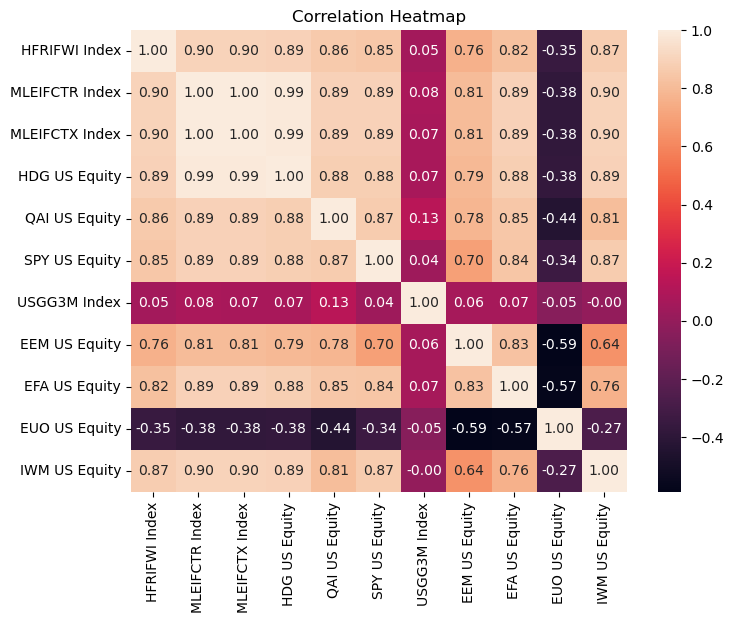

In [8]:
combined = pd.concat([df, ml_data], axis=1)
plt.figure(figsize=(8,6))
sns.heatmap(combined.corr(), annot=True, fmt='.2f')
plt.title('Correlation Heatmap')

The highest correlated series are the HDG US Equity series with the MLEIFCTX and MLEIFCTR indices at $0.99$. The MLEIFCTR and MLEIFCTX indices are also perfectly correlated, but they are both Merril Lynch series, so it's worth reporting the next highest correlated series.

The least correlated series (in terms of most uncorrelated—i.e., closest to 0) are the IWM US Equity and the USGG3M Index with a correlation of $0$. The least correlated series—in terms of most negatively correlated—are the EEM US Equity and EUO US Equity with a correlation of $-0.59$.

## 6. Replicate HFRI with the six factors listed on the “merrill factors” tab. Include a constant, and run the unrestricted regression,

$$
r_t^{\text{hfri}} = \alpha^{\text{merr}} + x_t^{\text{merr}} \beta^{\text{merr}} + \epsilon_t^{\text{merr}}
$$

$$
\hat{r}_t^{\text{hfri}} = \hat{\alpha}^{\text{merr}} + x_t^{\text{merr}} \hat{\beta}^{\text{merr}}
$$

Note that the second equation is just our notation for the fitted replication.

a. Report the intercept and betas.

b. Are the betas realistic position sizes, or do they require huge long-short positions?

c. Report the R-squared.

d. Report the volatility of $\epsilon_t^{\text{merr}}$, the tracking error.

In [9]:
hfri = df['HFRIFWI Index']
X = sm.add_constant(ml_data)
model = sm.OLS(hfri, X, missing='drop')
res = model.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:          HFRIFWI Index   R-squared:                       0.843
Model:                            OLS   Adj. R-squared:                  0.837
Method:                 Least Squares   F-statistic:                     144.6
Date:                Sun, 12 Oct 2025   Prob (F-statistic):           2.10e-62
Time:                        14:24:58   Log-Likelihood:                 605.85
No. Observations:                 169   AIC:                            -1198.
Df Residuals:                     162   BIC:                            -1176.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.0011      0.001      1.631

In [14]:
#the residual volatility/ tracking error
print(res.resid.std())

0.006731819236592867


In [26]:
# position weight of each factors
hfri_std = summ.loc['HFRIFWI Index', 'Volatility']
weight_df = pd.DataFrame(index = ml_data.columns, columns= ['Betas', 'Standard Deviation'])
weight_df['Betas'] = res.params
weight_df['Standard Deviation'] = ml_data.std()
weight_df['Weight'] = (hfri_std / weight_df['Standard Deviation']) * weight_df['Betas']

weight_df

,Betas,Standard Deviation,Weight
SPY US Equity,0.043503,0.041395,0.061791
USGG3M Index,0.324931,0.001580,12.094447
EEM US Equity,0.085564,0.051452,0.097777
EFA US Equity,0.073994,0.043643,0.099686
EUO US Equity,0.029614,0.045030,0.038668
IWM US Equity,0.145824,0.056769,0.151031


In [28]:
summ.loc['HFRIFWI Index', 'Volatility']

np.float64(0.05879633598432765)

a.
intercept = 0.0011
|Factors|Beta|
|:---:|:---:|
|SPY US Equity|0.0435|
|USGG3M Index|0.3249|
|EEM US Equity|0.0856|
|EFA US Equity|0.0740|
|EUO US Equity|0.0296|
|IWM US Equity|0.1458|

b. The betas are in realistic position sizes, as the largest beta is at 0.325. All the betas are small and of the same size, meaning that the replication with the factors will be in mildly long positions.

c. R^2 : 0.843

d. $\epsilon_t^{\text{merr}}$ : 0.0067318


## 7. Let’s examine the replication out-of-sample (OOS).

Starting with $t = 61$ month of the sample, do the following:

Use the previous 60 months of data to estimate the regression equation. This gives time-t estimates of the regression parameters, $\tilde{\alpha}_t^{\text{merr}}$ and $\tilde{\beta}_t^{\text{merr}}$.

Use the estimated regression parameters, along with the time-t regressor values, $x_t^{\text{merr}}$, to calculate the time-t replication value that is, with respect to the regression estimate, built “out-of-sample” (OOS).

$$
\hat{r}_t^{\text{hfri}} = \tilde{\alpha}^{\text{merr}} + (x_t^{\text{merr}})' \tilde{\beta}^{\text{merr}}
$$

Step forward to $t = 62$, and now use $t = 2$ through $t = 61$ for the estimation. Re-run the steps above, and continue this process throughout the data series. Thus, we are running a rolling, 60-month regression for each point-in-time.

How well does the out-of-sample replication perform with respect to the target?

In [9]:
preds = pd.Series(index=df.index)

for t in range(60, len(df)):
    y_train = df['HFRIFWI Index'].iloc[t-60:t]
    X_train = X.iloc[t-60:t]

    model = sm.OLS(y_train, X_train, missing='drop')
    res = model.fit()

    preds.iloc[t] = res.predict(X.iloc[t])

y_true = df['HFRIFWI Index'].iloc[60:]
y_hat = preds.iloc[60:]
print(f'MSE: {((y_true - y_hat)**2).mean()}')

MSE: 6.43389897265662e-05


## Constained Optimization

In [10]:
from scipy.optimize import minimize

data = pd.read_excel("spx_returns_weekly.xlsx", sheet_name="s&p500 rets")[["AAPL", "NVDA", "MSFT", "GOOGL", "AMZN", "META", "TSLA", "AVGO", "BRK/B", "LLY"]]
spy = pd.read_excel("spx_returns_weekly.xlsx", sheet_name="benchmark rets")["SPY"]
data["SPY"] = spy
data

,AAPL,NVDA,MSFT,GOOGL,AMZN,META,TSLA,AVGO,BRK/B,LLY,SPY
0,0.024514,-0.009315,0.009195,-0.054445,-0.037534,-0.009055,-0.057685,0.047971,0.002011,-0.001855,-0.005744
1,-0.053745,0.000836,-0.020131,0.019448,-0.020880,-0.032931,-0.065760,-0.010268,-0.001739,0.010726,-0.012827
2,0.065950,0.037578,0.020329,0.061685,0.074431,0.035255,0.042575,0.030500,-0.000603,0.020514,0.016565
3,0.036997,-0.072636,-0.143706,-0.008130,0.134900,-0.024669,0.011476,-0.038331,-0.034938,-0.001802,-0.026931
4,0.019114,0.062269,0.049753,-0.006812,0.055737,-0.018967,0.067589,0.018037,0.043569,-0.022778,0.030584
...,...,...,...,...,...,...,...,...,...,...,...
537,0.062442,0.093802,0.065447,0.071448,0.094896,0.091310,0.180553,0.124686,0.024604,0.053074,0.046029
538,-0.018778,0.031439,0.110833,0.012784,0.005238,0.090906,0.007931,0.058915,0.016649,-0.068872,0.029275
539,-0.033212,0.018777,0.007926,-0.068772,0.016212,-0.007588,0.038474,0.022392,-0.048277,-0.108120,-0.004270
540,0.065517,0.160737,0.037321,0.087989,0.064902,0.080761,0.173406,0.098031,0.001110,0.033180,0.052911


In [11]:
TARGET_MEAN = 0.2
FREQ = 52
mean = data.mean() * FREQ
cov = data.cov() * FREQ

#Objective function
def portfolio_variance(weights, cov):
    return weights.T @ cov @ weights

#Contstraints
def weights_sum_to_one(weights):
    return np.sum(weights) - 1

def target_weight(weights, mean, TARGET_MEAN):
    return weights @ mean - TARGET_MEAN

bounds = [(-0.2, 0.35) for _ in range(len(mean))]
w0 = np.ones(len(mean)) / len(mean)

constraints = ({'type': 'eq', 'fun': weights_sum_to_one},
               {'type': 'eq', 'fun': target_weight, 'args': (mean, TARGET_MEAN)})

opt = minimize(fun=portfolio_variance, x0=w0, args=(cov), bounds=bounds, constraints=constraints)
w_constrained = opt.x
w_constrained_df = pd.DataFrame(w_constrained, index=data.columns)
w_constrained_df = w_constrained_df.rename(columns={0:"Constrained Weights"})
w_constrained_df

,Constrained Weights
AAPL,0.029241
NVDA,-0.014344
MSFT,0.144508
GOOGL,0.009064
AMZN,0.093858
META,0.002874
TSLA,-0.015071
AVGO,0.036250
BRK/B,0.350000
LLY,0.213085


In [12]:
w_constrained_portfolio_rets = data @ w_constrained_df
w_constrained_portfolio_mean = w_constrained_portfolio_rets.mean() * FREQ
w_constrained_portfolio_vol = w_constrained_portfolio_rets.std() * np.sqrt(FREQ)
w_constrained_portfolio_sharpe = w_constrained_portfolio_mean / w_constrained_portfolio_vol
constrained_portfolio_performance = {"Annualized Mean": w_constrained_portfolio_mean, "Annualized Vol": w_constrained_portfolio_vol, "Annualized Sharpe": w_constrained_portfolio_sharpe}
constrained_portfolio_performance_df = pd.DataFrame(constrained_portfolio_performance)
constrained_portfolio_performance_df

,Annualized Mean,Annualized Vol,Annualized Sharpe
Constrained Weights,0.2,0.164889,1.212936


In [13]:
asset_performance = {}
asset_performance["Annualized Mean"] = data.mean() * FREQ
asset_performance["Annualized Vol"] = data.std() * np.sqrt(FREQ)
asset_performance["Annulized Sharpe Ratio"] = asset_performance["Annualized Mean"] / asset_performance["Annualized Vol"]
asset_performance_df = pd.DataFrame(asset_performance)
display(asset_performance_df, w_constrained_df)

,Annualized Mean,Annualized Vol,Annulized Sharpe Ratio
AAPL,0.238714,0.276629,0.862938
NVDA,0.645580,0.463283,1.393490
MSFT,0.261402,0.239980,1.089266
GOOGL,0.216800,0.279851,0.774698
AMZN,0.293447,0.306000,0.958976
META,0.261924,0.351336,0.745509
TSLA,0.469754,0.586431,0.801039
AVGO,0.394854,0.375132,1.052574
BRK/B,0.135025,0.190654,0.708223
LLY,0.281542,0.282980,0.994919


,Constrained Weights
AAPL,0.029241
NVDA,-0.014344
MSFT,0.144508
GOOGL,0.009064
AMZN,0.093858
META,0.002874
TSLA,-0.015071
AVGO,0.036250
BRK/B,0.350000
LLY,0.213085


We can see that the most extreme long position is in BRK/B, even though BRK/B has one of the lowest means and the lowest Sharpe Ratio out of all the assets. Similarly, we can see that TSLA which has the most extreme short positioin has a Sharpe ratio in the middle of the pack, and NVDA which has the only other short position actually has the largest mean and Sharpe Ratio. This shows that high means and Sharpe Ratios do not correspond to the highest weights in the constrained optimized portfolio. This is likely because the portfolio prioritizes diversifying assets over assets that simply have high returns, as that helps to improve the Sharpe Ratio of the overall portfolio. 

In [14]:
unconstrained_opt = minimize(fun=portfolio_variance, x0=w0, args=(cov), constraints=constraints)
w_unconstrained = unconstrained_opt.x
w_constrained_df["Unconstrained Weights"] = w_unconstrained
w_constrained_df

,Constrained Weights,Unconstrained Weights
AAPL,0.029241,0.029466
NVDA,-0.014344,-0.015325
MSFT,0.144508,0.152003
GOOGL,0.009064,0.008214
AMZN,0.093858,0.094934
META,0.002874,0.001967
TSLA,-0.015071,-0.014919
AVGO,0.036250,0.035449
BRK/B,0.350000,0.367594
LLY,0.213085,0.210526


In [15]:
w_unconstrained_portfolio_rets = data @ w_constrained_df["Unconstrained Weights"]
w_unconstrained_portfolio_mean = w_unconstrained_portfolio_rets.mean() * FREQ
w_unconstrained_portfolio_vol = w_unconstrained_portfolio_rets.std() * np.sqrt(FREQ)
w_unconstrained_portfolio_sharpe = w_unconstrained_portfolio_mean / w_unconstrained_portfolio_vol
unconstrained_portfolio_performance = {"Annualized Mean": w_unconstrained_portfolio_mean, "Annualized Vol": w_unconstrained_portfolio_vol, "Annualized Sharpe": w_unconstrained_portfolio_sharpe}
unconstrained_portfolio_performance_df = pd.DataFrame(unconstrained_portfolio_performance, index=["Unconstrained Weights"])
unconstrained_portfolio_performance_df

,Annualized Mean,Annualized Vol,Annualized Sharpe
Unconstrained Weights,0.2,0.164866,1.213103


In [16]:
comparison = pd.concat([constrained_portfolio_performance_df, unconstrained_portfolio_performance_df])
comparison

,Annualized Mean,Annualized Vol,Annualized Sharpe
Constrained Weights,0.2,0.164889,1.212936
Unconstrained Weights,0.2,0.164866,1.213103


We can see that the unconstrained portfolio had a slightly higher allocation to its most long position. This caused the Sharpe ratio of the unconstrained portfolio to be slightly better than the constrained portfolio, which makes sense as the positions were not bounded and could assume any value to maximize the Sharpe ratio. 